In [6]:
import numpy as np
from rashomon.hasse import enumerate_policies, enumerate_profiles, policy_to_profile
from rashomon.aggregate import RAggregate
from rashomon.metrics import find_best_policies
from rashomon.extract_pools import lattice_edges, extract_pools, aggregate_pools
from rashomon.aggregate import subset_data, find_profile_lower_bound
from rashomon.loss import compute_policy_means, compute_pool_means
import matplotlib.pyplot as plt
from rashomon.metrics import compute_all_metrics, make_predictions


# ALGORITHM 1: TWO-WAVE

## 1. Enumerate policies and profiles, build mappings

In [7]:
# ------------------------
# 1. ENUMERATE POLICIES AND PROFILES
# ------------------------
M = 3  # number of features
R = np.array([4, 3, 3])  # levels per feature


# Enumerate all policies and profiles
all_policies = enumerate_policies(M, R)
num_policies = len(all_policies)
profiles, profile_map = enumerate_profiles(M)
num_profiles = len(profiles)

# Profile index mappings (always by int index, not tuple)
policies_profiles = {}
policies_ids_profiles = {}

for k, profile in enumerate(profiles):
    # Find indices in all_policies whose profile matches this profile
    idxs = [i for i, p in enumerate(all_policies) if policy_to_profile(p) == profile]
    policies_ids_profiles[k] = idxs
    policies_profiles[k] = [all_policies[i] for i in idxs]

# Masked policies (remove baseline features for each profile)
policies_profiles_masked = {}
for k, profile in enumerate(profiles):
    profile_mask = [bool(v) for v in profile]
    masked_policies = [tuple([pol[i] for i in range(M) if profile_mask[i]]) for pol in policies_profiles[k]]
    policies_profiles_masked[k] = masked_policies

Get a safe value for H.

In [8]:
def get_max_possible_H(policies_profiles):
    """
    Returns robust (pre-allocation) max H across all profiles.
    """
    max_H = max(len(policies) for policies in policies_profiles.values())
    profile_H = {k: len(policies) for k, policies in policies_profiles.items()}
    return profile_H, max_H

# Usage:
profile_H, max_H = get_max_possible_H(policies_profiles)
print(f"Profile-wise max pools: {profile_H}")
print(f"Robust (safe) H for experiment: {robust_H}")

H = max_H # H is our chosen max number of pools per profile
lambda_reg = 0.1 # reg parameter
epsilon = 0.05

Profile-wise max pools: {0: 1, 1: 2, 2: 2, 3: 4, 4: 3, 5: 6, 6: 6, 7: 12}
Robust (safe) H for experiment: 12


## set up the underlying causal function and get ground truths

In [9]:
# Define causal function
def phi(policy):
    """Ground truth function (edit as needed for your scenario)."""
    x = np.array(policy)
    return 2 * x[0] + 0.5 * x[1]**2 + x[0]*x[2] + 0.2 * x[1] * x[2]

In [10]:
# Vector of ground truth means, in policy-index order
oracle_beta = np.array([phi(p) for p in all_policies])

# Full rankin g: indices sorted by oracle mean (descending)
oracle_full_order = np.argsort(-oracle_beta)  # highest first

# Map policy index to oracle rank (1=best)
oracle_ranks = np.empty_like(oracle_full_order)
oracle_ranks[oracle_full_order] = np.arange(1, len(oracle_beta)+1)

# Top-k indices, policies, and values
num_top = 10
top_k_indices = oracle_full_order[:num_top]
top_k_policies = [all_policies[i] for i in top_k_indices]
top_k_values = oracle_beta[top_k_indices]

for rank, (idx, pol, val) in enumerate(zip(top_k_indices, top_k_policies, top_k_values), 1):
    print(f"Rank {rank}: Index {idx}, Policy {list(map(int, pol))}, Value {val:.4f}")

Rank 1: Index 35, Policy [3, 2, 2], Value 14.8000
Rank 2: Index 32, Policy [3, 1, 2], Value 12.9000
Rank 3: Index 29, Policy [3, 0, 2], Value 12.0000
Rank 4: Index 34, Policy [3, 2, 1], Value 11.4000
Rank 5: Index 26, Policy [2, 2, 2], Value 10.8000
Rank 6: Index 31, Policy [3, 1, 1], Value 9.7000
Rank 7: Index 28, Policy [3, 0, 1], Value 9.0000
Rank 8: Index 23, Policy [2, 1, 2], Value 8.9000
Rank 9: Index 25, Policy [2, 2, 1], Value 8.4000
Rank 10: Index 33, Policy [3, 2, 0], Value 8.0000


## determine boundary probabilities and allocation

In [11]:
# first-wave boundary probability calculation
def boundary_probability(policy, R, H):
    prod = 1.0
    for i in range(len(policy)):
        vi = policy[i]
        Ri = R[i]
        numerator = 2 * min(vi, Ri - 1 - vi)
        denom = Ri - 1
        if denom == 0:
            continue
        factor = 1 - numerator / denom
        prod *= factor**(H-1)
    return 1 - prod

def compute_boundary_probabilities(all_policies, R, H):
    """Returns an array of probabilities for all policies."""
    return np.array([boundary_probability(p, R, H) for p in all_policies])


In [12]:
def get_allocations(probs, n1):
    """
    probs: array of length num_policies (boundary probabilities for each arm)
    n1: total first-wave sample size
    Returns integer allocation array (sum = n1)
    """
    total_prob = probs.sum()
    alloc_floats = n1 * probs / total_prob
    # Integer allocation: round, then correct for sum
    alloc_ints = np.floor(alloc_floats).astype(int)
    remainder = n1 - alloc_ints.sum()
    # Distribute remaining units to policies with largest fractional part
    if remainder > 0:
        frac = alloc_floats - alloc_ints
        idx_sorted = np.argsort(-frac)  # descending fractional part
        for i in idx_sorted[:remainder]:
            alloc_ints[i] += 1
    return alloc_ints

Get the boundary probabilities and allocate.

In [13]:
n1 = 100
boundary_probs = compute_boundary_probabilities(all_policies, R, H)
alloc1 = get_allocations(boundary_probs, n1)

print(f"Total allocated: {alloc1.sum()} (should be {n1})")

Total allocated: 100 (should be 100)


## create assignments and generate data

In [14]:
def create_assignments_from_alloc(alloc):
    """
    Given integer allocation vector over policies, returns a (n_1, 1) array of policy indices.
    """
    D = []
    for i, count in enumerate(alloc):
        if count > 0:
            D.extend([i] * count)
    D = np.array(D, dtype=int).reshape(-1, 1)
    return D

In [15]:
D1 = create_assignments_from_alloc(alloc1)  # (n_1, 1)

In [16]:
def generate_data_from_assignments(D, all_policies, phi, sig=1.0):
    """
    For a given list of policy indices (D), generate features X and outcomes y using phi.
    Arguments:
        D: (n, 1) array of assigned policy indices (ints from 0 to num_policies-1)
        all_policies: list of policy tuples (global)
        phi: function mapping policy tuple -> expected outcome
        var: outcome noise variance (can be scalar or array-like of same length as D)
    Returns:
        X: (n, M) array of assigned policy features
        y: (n, 1) array of outcomes
    """
    n = D.shape[0]
    X = np.zeros((n, len(all_policies[0])))
    y = np.zeros((n, 1))
    for i in range(n):
        v = all_policies[D[i, 0]]
        X[i, :] = v
        mu_i = phi(v)
        y[i, 0] = np.random.normal(loc=mu_i, scale=sig)
    return X, y

In [17]:
# Now generate X1 and y1 using the assignment-based generator:
X1, y1 = generate_data_from_assignments(D1, all_policies, phi, sig=4)

print(f"Wave 1 assignments (policy indices): {D1[:10].flatten()}")
print(f"Total n_1: {len(D1)} (should match allocation sum: {alloc1.sum()})")

Wave 1 assignments (policy indices): [1 1 1 1 3 3 3 4 4 4]
Total n_1: 100 (should match allocation sum: 100)


Print the minimum feasible value for H now that we know which profiles are observed here and which are unobserved.

In [18]:
def get_min_feasible_H(D, all_policies, profiles, policies_ids_profiles):
    """
    Returns the minimum feasible H for each profile (dict),
    and the global max across all observed profiles.
    """
    unique_policies_per_profile = {}
    for k in policies_ids_profiles:
        idxs = set(policies_ids_profiles[k])
        # Which units in D are assigned to profile k?
        mask = np.isin(D.flatten(), list(idxs))
        observed = D[mask].flatten() if np.any(mask) else []
        num_unique = len(np.unique(observed))
        unique_policies_per_profile[k] = num_unique
    global_H = max(unique_policies_per_profile.values())
    return unique_policies_per_profile, global_H

# Example usage (after D1 is constructed):
unique_policies, min_H = get_min_feasible_H(D1, all_policies, profiles, policies_ids_profiles)
print(f"Unique policies per profile: {unique_policies}")
print(f"Set H >= {min_H} for feasibility.")

Unique policies per profile: {0: 0, 1: 1, 2: 1, 3: 3, 4: 2, 5: 5, 6: 5, 7: 11}
Set H >= 11 for feasibility.


## Enumerate RPS

In [19]:
# Get mappings for profile subsets
def subset_wave_data_by_profile(D1, y1, all_policies, profiles, policies_ids_profiles):
    """
    For each profile, subset D1/y1 to only units assigned to this profile.
    Returns:
        D1_profiles: dict k -> (n_k, 1) policy indices (profile-local, 0-based)
        y1_profiles: dict k -> (n_k, 1) outcomes
        global_to_local: dict k -> dict mapping global policy idx to profile-local idx
    """
    D1_profiles = {}
    y1_profiles = {}
    global_to_local = {}
    for k, idxs in policies_ids_profiles.items():
        # Build set for fast membership
        idxs_set = set(idxs)
        # Mask: which units in D1 assigned to this profile?
        mask = np.array([d[0] in idxs_set for d in D1])
        if not np.any(mask):
            continue  # no data for this profile
        D1_k = D1[mask].flatten()
        y1_k = y1[mask]
        # Remap global indices to profile-local (as expected by RAggregate)
        glob2loc = {glob: loc for loc, glob in enumerate(idxs)}
        D1_k_profile = np.array([glob2loc[d] for d in D1_k]).reshape(-1, 1)
        D1_profiles[k] = D1_k_profile
        y1_profiles[k] = y1_k
        global_to_local[k] = glob2loc
    return D1_profiles, y1_profiles, global_to_local

In [20]:
# Compute policy means for each profile

def compute_profile_policy_means(D1_profiles, y1_profiles, policies_profiles):
    """
    For each profile, compute policy means/counts.
    Returns: dict k -> policy_means (num_policies_in_profile, 2)
    """
    profile_policy_means = {}
    for k in D1_profiles.keys():
        n_policies = len(policies_profiles[k])
        pm = compute_policy_means(D1_profiles[k], y1_profiles[k], n_policies)
        profile_policy_means[k] = pm
    return profile_policy_means

In [21]:
def build_global_wave_data(D1_profiles, y1_profiles, policies_profiles, profiles, policies_ids_profiles):
    """
    Stacks all observed profiles into arrays for RAggregate.
    (!!) converts local profile indices back to global indices using policies_ids_profiles.
    Returns D1_full (global indices), y1_full
    """
    # TODO make sure local to global is applied everywhere
    D_list, y_list = [], []
    for k in D1_profiles.keys():
        idxs = policies_ids_profiles[k]
        D1_k_profile = D1_profiles[k].flatten()
        # Map each local index back to its global policy index for this profile
        D1_k_global = np.array([idxs[local_idx] for local_idx in D1_k_profile]).reshape(-1, 1)
        D_list.append(D1_k_global)
        y_list.append(y1_profiles[k])
    D1_full = np.vstack(D_list)
    y1_full = np.vstack(y_list)
    return D1_full, y1_full

In [22]:
# # basic RPS construction
# def construct_RPS_basic(M, R, H, D1, y1, theta, reg=0.001, num_workers=1, verbose=False):
#     R_set, R_profiles = RAggregate(M, R, H, D1, y1, theta, reg=reg, num_workers=num_workers, verbose=verbose)
#     return R_set, R_profiles

In [23]:
# get top k policies for adaptive work
def find_top_k_policies(D, y_pred, k):
    idx_sorted = np.argsort(-y_pred.flatten())
    D_flat = D.flatten()[idx_sorted]
    _, unique_idx = np.unique(D_flat, return_index=True)
    top_k = D_flat[np.sort(unique_idx)][:k]
    return top_k

In [24]:
def construct_RPS_adaptive(
    M, R, H, D_full, y_full, num_top, policies_profiles_masked, policies_ids_profiles,
    profiles, all_policies, top_k_indices,
    theta_init,  # precomputed lower bound or baseline theta
    reg=0.1, max_factor=2.0, step_ratio=5, verbose=True,
    adaptive=False,  # pass if already computed for efficiency
    recovery_type="arm"  # "arm" (policy index) or "profile"
):
    # TODO later will need to remove the top_k_indices argumetn to make this usable without oracle. Just for interpretation right now.
    """
    Adaptive Rashomon set construction:
    Increments theta until RPS contains a partition whose best arm(s)
    (or profile) include the oracle-best.

    Returns:
        R_set, R_profiles, theta, found, theta_trace, rps_size_trace,
        per_partition: dict of lists (all same len = Rashomon set size), including:
            - best_pred_indices (top-k for each partition)
            - best_pred_profiles
            - regret (oracle minus predicted mean)
            - pool_means_r (per-partition policy means)
            - y_r_est (per-partition predictions)
            - pool_assignments (policy -> pool id mapping)
            - total_loss (loss for this partition)
    """

    # get starting threshold
    theta = theta_init
    theta_step = theta_init / step_ratio
    max_theta = theta_init * max_factor
    found = False
    iteration = 0
    theta_trace = []
    rps_size_trace = []

    # True best policies/profiles
    if recovery_type == "profile":
        best_targets = set(policy_to_profile(all_policies[idx]) for idx in top_k_indices)
    else:
        best_targets = set(top_k_indices)

    from rashomon.loss import compute_policy_means
    policy_means = compute_policy_means(D_full, y_full, len(all_policies))


    # update theta until actual best arm or profile is included
    while not found and theta <= max_theta:
        if verbose and adaptive:
            print(f"Trying theta={theta:.6f}")
        R_set, R_profiles = RAggregate(
            M, R, H, D_full, y_full, theta, reg=reg, num_workers=1, verbose=verbose
        )
        theta_trace.append(theta)
        rps_size_trace.append(len(R_set))
        if len(R_set) == 0:
            theta += theta_step * theta_init
            iteration += 1
            continue

        # For each partition in the Rashomon set, check recovery
        for r_set in R_set:
            # Assign pools for each profile
            pi_policies_profiles_r = {}
            for k, profile in enumerate(profiles):
                if len(R_profiles[k]) == 0:
                    continue
                sigma_k = R_profiles[k].sigma[r_set[k]]
                if sigma_k is None:
                    n_policies_profile = len(policies_profiles_masked[k])
                    pi_policies_r_k = {i: 0 for i in range(n_policies_profile)}
                else:
                    _, pi_policies_r_k = extract_pools(
                        policies_profiles_masked[k], sigma_k)
                pi_policies_profiles_r[k] = pi_policies_r_k

            pi_pools_r, pi_policies_r = aggregate_pools(
                pi_policies_profiles_r, policies_ids_profiles)
            pool_means_r = compute_pool_means(policy_means, pi_pools_r)
            y_r_est = make_predictions(D_full, pi_policies_r, pool_means_r)
            best_pred_indices = find_top_k_policies(D_full, y_r_est, num_top)

            if recovery_type == "profile":
                # check if any predicted best matched the best
                found_profiles = set(policy_to_profile(all_policies[idx]) for idx in best_pred_indices)
                if best_targets & found_profiles:
                    found = True
                    if verbose:
                        print("----FOUND-----")
                        print("actual best profile(s): ", best_targets)
                        print("found profile(s): ", found_profiles)
                    break
            else:  # "arm"
                if best_targets & set(best_pred_indices):
                    found = True
                    if verbose:
                        print("----FOUND-----")
                        print("actual best arms: ", [int(x) for x in best_targets])
                        print("best predicted arms: ", [int(x) for x in set(best_pred_indices)])
                    break

        if verbose:
            print("Size of RPS", len(R_set))
        if adaptive == False:
            break
        if not found:
            theta += theta_step * theta_init
            iteration += 1

    if adaptive and not found:
        print(f"Warning: max_theta reached without finding a Rashomon partition covering the best {recovery_type}.")
    if adaptive and verbose:
        print(f"Final theta for RPS: {theta:.4f} (after {iteration} iterations)")

    return R_set, R_profiles, theta, found, theta_trace, rps_size_trace

In [25]:
# Subset D1, y1 by profile and remap indices
D1_profiles, y1_profiles, global_to_local = subset_wave_data_by_profile(
    D1, y1, all_policies, profiles, policies_ids_profiles
)

In [26]:
# Compute per-profile policy means
profile_policy_means = compute_profile_policy_means(D1_profiles, y1_profiles, policies_profiles)

# check which profile has highest observed mean
for k in profile_policy_means:
    pm = profile_policy_means[k]
    means = pm[:,0] / np.maximum(pm[:,1], 1)
    print(f"Profile {k}: Max observed mean = {means.max():.3f}")

Profile 1: Max observed mean = 0.000
Profile 2: Max observed mean = 3.291
Profile 3: Max observed mean = 5.285
Profile 4: Max observed mean = 6.093
Profile 5: Max observed mean = 6.679
Profile 6: Max observed mean = 6.056
Profile 7: Max observed mean = 13.082


In [27]:
# stack all observed units for global RAggregate (this stacks D1/y1 for all observed profiles)
D1_full, y1_full = build_global_wave_data(D1_profiles, y1_profiles, policies_profiles, profiles, policies_ids_profiles)

In [28]:
# get lower bound for theta -- instead of the adaptive version
profile_lower_bounds = []
for k, profile in enumerate(profiles):
    Dk, yk = subset_data(D1_full, y1_full, policies_ids_profiles[k])
    if Dk is None:
        continue
    n_policies_k = len(policies_profiles[k])
    pm = compute_policy_means(Dk, yk, n_policies_k)
    profile_lb = find_profile_lower_bound(Dk, yk, pm)
    profile_lower_bounds.append(profile_lb)
theta_global = sum(profile_lower_bounds) * (1+epsilon)
print("theta_global: ", theta_global)

theta_global:  1179.1816008911176


In [29]:
# looking at 7 in this example
k = 7  # profile index for (1,1,1)
print("Profile 7: policy indices (global)", policies_ids_profiles[k])
print("Profile 7: number of unique observed policies:", len(np.unique(D1.flatten()[np.isin(D1.flatten(), policies_ids_profiles[k])])))

Profile 7: policy indices (global) [13, 14, 16, 17, 22, 23, 25, 26, 31, 32, 34, 35]
Profile 7: number of unique observed policies: 11


In [30]:
# OPTION 1-----
# R_set_other, R_profiles_other = construct_RPS(M, R, H, D1_full, y1_full, theta_global, reg=lambda_reg, num_workers=1, verbose=True)

# OPTION 2 -----  Run the adaptive Rashomon constructor:
# doing non-adaptive
R_set, R_profiles, theta_final, found_best, theta_trace, rps_size_trace = construct_RPS_adaptive(
    M, R, H, D1_full, y1_full, num_top, policies_profiles_masked, policies_ids_profiles, profiles, all_policies, top_k_indices, theta_global, reg=lambda_reg, adaptive=False, verbose=True, recovery_type = "arm"
)

Skipping profile (0, 0, 0)
(0, 0, 1) 1167.9795890413675
Adaptive
Profile (0, 0, 1) took 0.0029010772705078125 s adaptively
Profile (0, 0, 1) has 2 objects in Rashomon set
(0, 1, 0) 1168.271646153301
Adaptive
Profile (0, 1, 0) took 0.0006411075592041016 s adaptively
Profile (0, 1, 0) has 2 objects in Rashomon set
(0, 1, 1) 1168.2630740109798
Adaptive
Profile (0, 1, 1) took 0.0026390552520751953 s adaptively
Profile (0, 1, 1) has 4 objects in Rashomon set
(1, 0, 0) 1168.516216048313
Adaptive
Profile (1, 0, 0) took 0.001501321792602539 s adaptively
Profile (1, 0, 0) has 4 objects in Rashomon set
(1, 0, 1) 1170.2535234673132
Adaptive
Profile (1, 0, 1) took 0.012575864791870117 s adaptively
Profile (1, 0, 1) has 8 objects in Rashomon set
(1, 1, 0) 1169.441030405605
Adaptive
Profile (1, 1, 0) took 0.00800180435180664 s adaptively
Profile (1, 1, 0) has 8 objects in Rashomon set
(1, 1, 1) 1174.1643213457367
Adaptive
Profile (1, 1, 1) took 0.018484115600585938 s adaptively
Profile (1, 1, 1) has

In [31]:
print("Top-k best policies and their profiles:")
for rank, idx in enumerate(top_k_indices, 1):
    policy = all_policies[idx]
    profile = policy_to_profile(policy)
    print(f"Rank {rank}: Policy idx {idx}, Policy {[int(i) for i in policy]}, Profile {profile}")
# 3. Inspect the results
print(f"Adaptive RPS size: {len(R_set)}")
if found_best:
    print("Rashomon set contains a partition that recovers at least one oracle-best arm.")
else:
    print("Warning: No Rashomon partition found with an oracle-best arm within threshold.")

Top-k best policies and their profiles:
Rank 1: Policy idx 35, Policy [3, 2, 2], Profile (1, 1, 1)
Rank 2: Policy idx 32, Policy [3, 1, 2], Profile (1, 1, 1)
Rank 3: Policy idx 29, Policy [3, 0, 2], Profile (1, 0, 1)
Rank 4: Policy idx 34, Policy [3, 2, 1], Profile (1, 1, 1)
Rank 5: Policy idx 26, Policy [2, 2, 2], Profile (1, 1, 1)
Rank 6: Policy idx 31, Policy [3, 1, 1], Profile (1, 1, 1)
Rank 7: Policy idx 28, Policy [3, 0, 1], Profile (1, 0, 1)
Rank 8: Policy idx 23, Policy [2, 1, 2], Profile (1, 1, 1)
Rank 9: Policy idx 25, Policy [2, 2, 1], Profile (1, 1, 1)
Rank 10: Policy idx 33, Policy [3, 2, 0], Profile (1, 1, 0)
Adaptive RPS size: 4085
Rashomon set contains a partition that recovers at least one oracle-best arm.


In [32]:
# Gather observed policy indices (in wave 1)
observed_policy_indices = set(D1.flatten())
# Gather observed profiles (in wave 1)
observed_profiles = set()
for idx in observed_policy_indices:
    prof = policy_to_profile(all_policies[idx])
    observed_profiles.add(prof)

print("\nObserved profiles in data:", observed_profiles)
print("Are all top-k best profiles observed?")

for rank, idx in enumerate(top_k_indices, 1):
    policy = all_policies[idx]
    prof = policy_to_profile(policy)
    print(f"Best Policy {idx}: Profile {prof}, Observed? {prof in observed_profiles}")


Observed profiles in data: {(1, 0, 1), (1, 1, 0), (0, 1, 0), (1, 0, 0), (0, 0, 1), (1, 1, 1), (0, 1, 1)}
Are all top-k best profiles observed?
Best Policy 35: Profile (1, 1, 1), Observed? True
Best Policy 32: Profile (1, 1, 1), Observed? True
Best Policy 29: Profile (1, 0, 1), Observed? True
Best Policy 34: Profile (1, 1, 1), Observed? True
Best Policy 26: Profile (1, 1, 1), Observed? True
Best Policy 31: Profile (1, 1, 1), Observed? True
Best Policy 28: Profile (1, 0, 1), Observed? True
Best Policy 23: Profile (1, 1, 1), Observed? True
Best Policy 25: Profile (1, 1, 1), Observed? True
Best Policy 33: Profile (1, 1, 0), Observed? True


In [33]:
for k, rprof in enumerate(R_profiles):
    print(f"Profile {k}: {len(rprof)} poolings in RPS (if observed)")
print(f"First-wave Rashomon set: {len(R_set)} feasible global partitions (combinations of per-profile poolings).")
# You now have R_set (list of feasible global partition indices) and R_profiles (list of per-profile RashomonSets)

Profile 0: 1 poolings in RPS (if observed)
Profile 1: 2 poolings in RPS (if observed)
Profile 2: 2 poolings in RPS (if observed)
Profile 3: 4 poolings in RPS (if observed)
Profile 4: 4 poolings in RPS (if observed)
Profile 5: 8 poolings in RPS (if observed)
Profile 6: 8 poolings in RPS (if observed)
Profile 7: 13 poolings in RPS (if observed)
First-wave Rashomon set: 4085 feasible global partitions (combinations of per-profile poolings).


f#### (optional) can look at plots of size, epsilon, and loss

Some plots after the first construction of the RPS to look at RPS size and epsilon, and the error distribution:

In [34]:
def plot_rps_size_vs_epsilon(aggregate_func, M, R, H, D1_full, y1_full, base_theta, reg=1e-5, epsilons=None):
    """
    Plots RPS size vs epsilon. aggregate_func = RAggregate or similar.
    """
    if epsilons is None:
        epsilons = np.linspace(0.01, 0.2, 10)  # sweep from 1% to 20% above min loss
    set_sizes = []
    min_loss = None
    for eps in epsilons:
        theta = base_theta * (1 + eps)
        R_set, R_profiles = aggregate_func(M, R, H, D1_full, y1_full, theta, reg=reg)
        set_sizes.append(len(R_set))
        # Find MAP (min loss) if needed
        if min_loss is None and len(R_set) > 0:
            # Min loss over all models in this set
            min_loss = min(
                sum(R_profiles[k].loss[r[profile]] for k, profile in enumerate(r))
                for r in R_set
            )
    plt.figure(figsize=(6, 4))
    plt.plot(epsilons, set_sizes, marker='o')
    plt.xlabel(r'$\epsilon$')
    plt.ylabel('Rashomon Set Size')
    plt.title('RPS Size vs. Loss Tolerance')
    plt.axvline(x=0.05, color='r', linestyle='--', label='Baseline epsilon')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Usage after constructing D1_full, y1_full:
# plot_rps_size_vs_epsilon(RAggregate, M, R, H, D1_full, y1_full, theta_global, reg=1e-5)

In [35]:
def plot_rps_loss_histogram(R_set, R_profiles):
    """
    Plot histogram of losses across Rashomon set (sum over profiles).
    """
    if len(R_set) == 0:
        print("Empty Rashomon set.")
        return
    losses = []
    for r in R_set:
        total_loss = sum(R_profiles[k].loss[r[k]] for k in range(len(r)))
        losses.append(total_loss)
    plt.figure(figsize=(6, 4))
    plt.hist(losses, bins=20, color='dodgerblue', alpha=0.7)
    plt.axvline(min(losses), color='r', linestyle='--', label='MAP loss')
    plt.xlabel('Total Loss')
    plt.ylabel('Count')
    plt.title('Loss Distribution in RPS')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Usage:
# plot_rps_loss_histogram(R_set, R_profiles)

In [36]:
# plot_rps_size_vs_epsilon(RAggregate, M, R, H, D1_full, y1_full, theta_global, reg=lambda_reg)

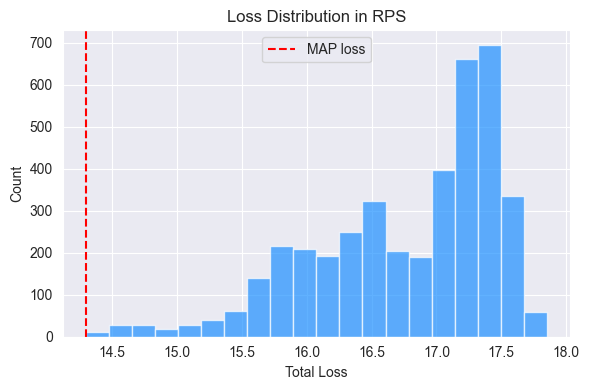

In [37]:
plot_rps_loss_histogram(R_set, R_profiles)

## get second wave boundary probabilities and allocation

In [38]:
def get_policy_neighbors(all_policies):
    """
    Uses lattice_edges helper to get neighbor map for policies.
    """
    edges = lattice_edges(all_policies)  # list of (i, j)
    neighbors = {i: [] for i in range(len(all_policies))}
    for i, j in edges:
        neighbors[i].append(j)
        neighbors[j].append(i)  # edges are undirected
    return neighbors

# Usage:
# neighbors = get_policy_neighbors_from_edges(all_policies)

In [39]:
def compute_global_boundary_matrix(
    R_set, R_profiles, neighbors, profiles, policies_profiles_masked, policies_ids_profiles, all_policies
):
    """
    Returns boundary_matrix: shape (n_partitions, num_policies)
    boundary_matrix[j, i] = number of boundaries for policy i in partition j
    (i.e., number of neighbors in a different pool)
    """
    num_policies = len(all_policies)
    n_partitions = len(R_set)

    boundary_matrix = np.zeros((n_partitions, num_policies), dtype=int)

    for j, r in enumerate(R_set):
        pi_policies_profiles_r = {}
        for k, profile in enumerate(profiles):
            if len(R_profiles[k]) == 0:
                continue
            sigma_k = R_profiles[k].sigma[r[k]]
            if sigma_k is None:
                continue
            _, pi_policies_k = extract_pools(policies_profiles_masked[k], sigma_k)
            pi_policies_profiles_r[k] = pi_policies_k
        pi_pools_r, pi_policies_r = aggregate_pools(pi_policies_profiles_r, policies_ids_profiles)
        for i in range(num_policies):
            pool_i = pi_policies_r.get(i, -1)
            if pool_i == -1:
                continue
            # Count number of neighbors in a different pool
            count = 0
            for nb in neighbors[i]:
                pool_nb = pi_policies_r.get(nb, -1)
                if pool_nb != -1 and pool_nb != pool_i:
                    count += 1
            boundary_matrix[j, i] = count
    return boundary_matrix

In [40]:
def get_posterior_weights(R_set, R_profiles):

    losses = np.array([sum(R_profiles[k].loss[r[k]] for k in range(len(r))) for r in R_set])
    weights = np.exp(-losses)
    weights /= weights.sum() if weights.sum() > 0 else 1.0

    return weights

In [41]:
neighbors = get_policy_neighbors(all_policies)

In [42]:
boundary_matrix = compute_global_boundary_matrix(R_set, R_profiles, neighbors, profiles, policies_profiles_masked, policies_ids_profiles, all_policies)
binary_boundary_matrix = (boundary_matrix > 0).astype(float)


In [43]:
posterior_weights = get_posterior_weights(R_set, R_profiles)

In [44]:
# Weighted average across partitions
posterior_boundary_probs = np.average(binary_boundary_matrix, axis=0, weights=posterior_weights)
# posterior_weighted_boundary_probs[i]: average number of boundaries for policy i, weighted by RPS posterior
# Usage:
posterior_boundary_probs = np.round(posterior_boundary_probs, decimals=8)


In [45]:
# 1. Basic shape check
assert posterior_boundary_probs.shape == (len(all_policies),), "Posterior vector shape mismatch"

# 2. Check range and sum
print("Posterior boundary min/max:", posterior_boundary_probs.min(), posterior_boundary_probs.max())
# 3. Check for degenerate values
assert np.all((posterior_boundary_probs >= 0) & (posterior_boundary_probs <= 1)), "Probabilities out of bounds"

Posterior boundary min/max: 0.0 1.0


## Next waves

In [48]:
# Set n2 (second-wave sample size, e.g., same as n1 or a new value)
n2 = 100

# posterior_boundary_probs: already computed above, vector of length num_policies
# Use the same allocation function as for wave 1
alloc2 = get_allocations(posterior_boundary_probs, n2)

print(f"Second-wave allocations (first 10): {alloc2[:10]}")
print(f"Total allocated: {alloc2.sum()} (should be {n2})")

Second-wave allocations (first 10): [0 3 3 3 3 3 3 2 3 3]
Total allocated: 100 (should be 100)


In [50]:
# Assignments (policy indices) for wave 2
D2 = create_assignments_from_alloc(alloc2)  # (n2, 1)

# Generate new features and outcomes for wave 2
X2, y2 = generate_data_from_assignments(D2, all_policies, phi, sig=4)

print(f"Wave 2 assignments (policy indices): {D2[:10].flatten()}")
print(f"Wave 2 features X2: {X2[:5, :]}")
print(f"Wave 2 outcomes y2: {y2[:5, 0]}")
print(f"Total n_2: {len(D2)} (should match allocation sum: {alloc2.sum()})")

Wave 2 assignments (policy indices): [1 1 1 2 2 2 3 3 3 4]
Wave 2 features X2: [[0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 2.]
 [0. 0. 2.]]
Wave 2 outcomes y2: [-6.52647703  4.39804512 -3.49858632 -0.22764589  0.79703716]
Total n_2: 100 (should match allocation sum: 100)


## construct updated RPS

In [51]:
# --- Combine data for both waves ---
D_total = np.vstack([D1, D2])
y_total = np.vstack([y1, y2])

# --- Subset and remap ---
D_total_profiles, y_total_profiles, global_to_local_total = subset_wave_data_by_profile(
    D_total, y_total, all_policies, profiles, policies_ids_profiles
)

profile_policy_means_total = compute_profile_policy_means(D_total_profiles, y_total_profiles, policies_profiles)

# --- Stack all observed units into D_total_full, y_total_full (global indices) ---
D_total_full, y_total_full = build_global_wave_data(
    D_total_profiles, y_total_profiles, policies_profiles, profiles, policies_ids_profiles
)

In [52]:
# --- Get profile lower bounds and global theta ---
profile_lower_bounds_total = []
for k in D_total_profiles:
    Dk, yk = subset_data(D_total_full, y_total_full, policies_ids_profiles[k])
    if Dk is None:
        continue
    n_policies_k = len(policies_profiles[k])
    pm = compute_policy_means(Dk, yk, n_policies_k)
    profile_lb = find_profile_lower_bound(Dk, yk, pm)
    profile_lower_bounds_total.append(profile_lb)
theta_global_total = sum(profile_lower_bounds_total) * (1.05)  # adjust epsilon as needed

print("theta_global (final): ", theta_global_total) # TODO should we be updating the threshold for each wave??

theta_global (final):  3330.7977245413767


In [53]:
# --- Run Rashomon set construction as in first wave ---
R_set_total, R_profiles_total, theta_final, found_best, theta_trace, rps_size_trace = construct_RPS_adaptive(
    M, R, H, D_total_full, y_total_full, num_top, policies_profiles_masked, policies_ids_profiles,
    profiles, all_policies, top_k_indices, theta_global_total, reg=lambda_reg, adaptive=False, verbose=True, recovery_type="arm"
)

print(f"Final Rashomon set: {len(R_set_total)} feasible global partitions (with all data).")
for k, rprof in enumerate(R_profiles_total):
    print(f"Profile {k}: {len(rprof)} poolings in RPS (if observed)")

Skipping profile (0, 0, 0)
(0, 0, 1) 3315.3716105646517
Adaptive
Profile (0, 0, 1) took 0.0009157657623291016 s adaptively
Profile (0, 0, 1) has 2 objects in Rashomon set
(0, 1, 0) 3315.328999722647
Adaptive
Profile (0, 1, 0) took 0.0005850791931152344 s adaptively
Profile (0, 1, 0) has 2 objects in Rashomon set
(0, 1, 1) 3315.648975662898
Adaptive
Profile (0, 1, 1) took 0.0012400150299072266 s adaptively
Profile (0, 1, 1) has 4 objects in Rashomon set
(1, 0, 0) 3316.223119642091
Adaptive
Profile (1, 0, 0) took 0.0009601116180419922 s adaptively
Profile (1, 0, 0) has 4 objects in Rashomon set
(1, 0, 1) 3318.239705391663
Adaptive
Profile (1, 0, 1) took 0.0035240650177001953 s adaptively
Profile (1, 0, 1) has 8 objects in Rashomon set
(1, 1, 0) 3316.9232756406636
Adaptive
Profile (1, 1, 0) took 0.0032896995544433594 s adaptively
Profile (1, 1, 0) has 8 objects in Rashomon set
(1, 1, 1) 3322.6827358924115
Adaptive
Profile (1, 1, 1) took 0.010460853576660156 s adaptively
Profile (1, 1, 1) 

In [54]:
# Compute boundary masks/probabilities as before for both waves:
boundary_matrix_1 = compute_global_boundary_matrix(R_set, R_profiles, neighbors, profiles, policies_profiles_masked, policies_ids_profiles, all_policies)
binary_boundary_matrix_1 = (boundary_matrix_1 > 0).astype(float)

posterior_boundary_probs_1 = np.average(binary_boundary_matrix_1, axis=0, weights=get_posterior_weights(R_set, R_profiles))

# get probabilities after
boundary_matrix_2 = compute_global_boundary_matrix( R_set_total, R_profiles_total, neighbors, profiles, policies_profiles_masked, policies_ids_profiles, all_policies)
binary_boundary_matrix_2 = (boundary_matrix_2 > 0).astype(float)

posterior_boundary_probs_2 = np.average(binary_boundary_matrix_2, axis=0, weights=get_posterior_weights(R_set_total, R_profiles_total))

# Compare statistics:
diff = posterior_boundary_probs_2 - posterior_boundary_probs_1
print("Number of policies with DECREASED boundary probability:", (diff < -0.0001).sum())
print("Number of policies with INCREASED boundary probability:", (diff > 0.0001).sum())
print("Mean change in boundary probability:", diff.mean())
print("Fraction of policies now at 0 boundary probability:", (posterior_boundary_probs_2 < 1e-8).mean())
print("Fraction now at 1 boundary probability:", (posterior_boundary_probs_2 > 1 - 1e-8).mean())


Number of policies with DECREASED boundary probability: 2
Number of policies with INCREASED boundary probability: 0
Mean change in boundary probability: -0.0039355422581625575
Fraction of policies now at 0 boundary probability: 0.027777777777777776
Fraction now at 1 boundary probability: 0.9166666666666666


In [55]:
for idx in np.argsort(-np.abs(diff))[:10]:
    print(f"Policy {idx} {[int(x) for x in all_policies[idx]]}: wave1={posterior_boundary_probs_1[idx]:.3f}, wave2={posterior_boundary_probs_2[idx]:.3f}, delta={diff[idx]:.10f}")


Policy 35 [3, 2, 2]: wave1=0.729, wave2=0.627, delta=-0.1017893982
Policy 26 [2, 2, 2]: wave1=0.885, wave2=0.845, delta=-0.0398901231
Policy 32 [3, 1, 2]: wave1=1.000, wave2=1.000, delta=0.0000000000
Policy 31 [3, 1, 1]: wave1=1.000, wave2=1.000, delta=0.0000000000
Policy 30 [3, 1, 0]: wave1=1.000, wave2=1.000, delta=0.0000000000
Policy 29 [3, 0, 2]: wave1=1.000, wave2=1.000, delta=0.0000000000
Policy 28 [3, 0, 1]: wave1=1.000, wave2=1.000, delta=0.0000000000
Policy 27 [3, 0, 0]: wave1=1.000, wave2=1.000, delta=0.0000000000
Policy 19 [2, 0, 1]: wave1=1.000, wave2=1.000, delta=0.0000000000
Policy 25 [2, 2, 1]: wave1=1.000, wave2=1.000, delta=0.0000000000


In [ ]:
# # still have neighbors = get_policy_neighbors(all_policies) from before
# boundary_matrix_2 = compute_global_boundary_matrix(
#     R_set_2, R_profiles_2, neighbors, profiles, policies_profiles_masked, policies_ids_profiles, all_policies
# )
# binary_boundary_matrix_2 = (boundary_matrix_2 > 0).astype(float)
# partition_losses_2, posterior_weights_2 = get_partition_losses(R_set_2, R_profiles_2)
# posterior_boundary_probs_2 = np.average(binary_boundary_matrix_2, axis=0, weights=posterior_weights_2)
#
# # to avoid small numerical errors, round to 8 decimal
# posterior_boundary_probs = np.round(posterior_boundary_probs_2, decimals=8)
# # Diagnostics: Compare boundary probabilities before/after second wave
# diff = posterior_boundary_probs_2 - posterior_boundary_probs_1
# print("Number of policies with DECREASED boundary probability:", (diff < -0.00001).sum())
# print("Number of policies with INCREASED boundary probability:", (diff > 0.00001).sum())
# print("Mean change in boundary probability:", diff.mean())
# print("Fraction of policies now at 0 boundary probability:", (posterior_boundary_probs_2 < 1e-8).mean())
# print("Fraction now at 1 boundary probability:", (posterior_boundary_probs_2 > 1 - 1e-8).mean())
#
# # optional - identify largest changes in boundary
# for idx in np.argsort(-np.abs(diff))[:10]:
#     print(
#         f"Policy {idx} {[int(x) for x in all_policies[idx]]}: wave1={posterior_boundary_probs_1[idx]:.3f}, wave2={posterior_boundary_probs_2[idx]:.3f}, delta={diff[idx]:.10f}")

# ALGORITHM 1: Regret, Evaluation, Visualizations

In [56]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

In [57]:
regrets = []
contains_best = []
best_pred_indices_all = []
policy_indices_all = []
policy_means_all = []
# Compute policy means for all observed data in both waves (or all waves)
policy_means_total = compute_policy_means(D_total_full, y_total_full, len(all_policies))
for i, r_set in enumerate(R_set_total):
    pi_policies_profiles_r = {}
    for k, profile in enumerate(profiles):
        if len(R_profiles_total[k]) == 0:
            continue
        sigma_k = R_profiles_total[k].sigma[r_set[k]]
        if sigma_k is None:
            n_policies_profile = len(policies_profiles_masked[k])
            pi_policies_r_k = {i: 0 for i in range(n_policies_profile)}
        else:
            _, pi_policies_r_k = extract_pools(policies_profiles_masked[k], sigma_k)
        pi_policies_profiles_r[k] = pi_policies_r_k

    pi_pools_r, pi_policies_r = aggregate_pools(pi_policies_profiles_r, policies_ids_profiles)
    pool_means_r = compute_pool_means(policy_means_total, pi_pools_r) # TODO this is now listed as not defined

    # For all policies
    policy_indices = np.array(list(pi_policies_r.keys()))
    policy_means = np.array([pool_means_r[pi_policies_r[idx]] for idx in policy_indices])

    # For reporting and analysis
    policy_indices_all.append(policy_indices)
    policy_means_all.append(policy_means)

    # For best-arm regret/recovery
    best_pred_idx = policy_indices[np.argmax(policy_means)]
    regrets.append(float(oracle_beta[top_k_indices[0]] - pool_means_r[pi_policies_r[best_pred_idx]]))
    contains_best.append(int(best_pred_idx == top_k_indices[0]))
    best_pred_indices_all.append(best_pred_idx)

regrets = np.array(regrets)
contains_best = np.array(contains_best)

In [58]:
# Compute partition losses, MAP index, and posterior weights
partition_losses = np.array([
    sum(R_profiles_total[k].loss[r_set[k]] for k in range(len(r_set)))
    for r_set in R_set_total
])
weights = np.exp(-partition_losses)
weights /= weights.sum() if weights.sum() > 0 else 1.0

map_idx = np.argmin(partition_losses)
r_set_map = R_set_total[map_idx]

MAP Rank | Policy Idx | Pred Val | Oracle Val | Oracle Rank | Top-k?
-----------------------------------------------------------------
       1 |         26 |   10.509 |     10.800 |           5 | YES   
       2 |         34 |   10.509 |     11.400 |           4 | YES   
       3 |         25 |   10.509 |      8.400 |           9 | YES   
       4 |         35 |   10.509 |     14.800 |           1 | YES   
       5 |         28 |    9.771 |      9.000 |           7 | YES   
       6 |         29 |    9.771 |     12.000 |           3 | YES   
       7 |         23 |    7.436 |      8.900 |           8 | YES   
       8 |         32 |    7.436 |     12.900 |           2 | YES   
       9 |         31 |    7.436 |      9.700 |           6 | YES   
      10 |         22 |    7.436 |      6.700 |          13 |       
      11 |         17 |    6.316 |      6.800 |          12 |       
      12 |         16 |    6.316 |      5.400 |          18 |       
      13 |         27 |    6.307 |   

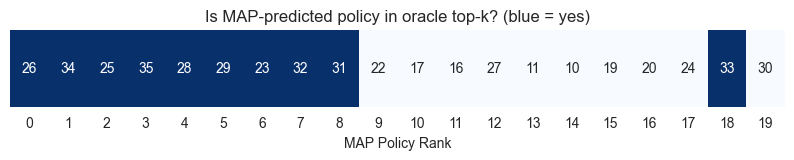

In [59]:
# --- MAP partition: pull all needed values from arrays you already computed ---

policy_indices_map = policy_indices_all[map_idx]
policy_means_map = policy_means_all[map_idx]

# Sort the policies by predicted mean (descending)
order = np.argsort(-policy_means_map)
sorted_idx = policy_indices_map[order]
sorted_means = policy_means_map[order]

N = 20  # Show top-N MAP-predicted policies

# For each policy: true oracle value, oracle rank, is it in top-k?
oracle_values = oracle_beta[sorted_idx[:N]]
oracle_ranks_map = oracle_ranks[sorted_idx[:N]]
is_topk = [idx in top_k_indices for idx in sorted_idx[:N]]

print(f"{'MAP Rank':>8} | {'Policy Idx':>10} | {'Pred Val':>8} | {'Oracle Val':>10} | {'Oracle Rank':>11} | {'Top-k?':>6}")
print('-'*65)
for map_rank, (idx, pred, true, rnk, flag) in enumerate(zip(sorted_idx[:N], sorted_means[:N], oracle_values, oracle_ranks_map, is_topk), 1):
    tag = "YES" if flag else ""
    print(f"{map_rank:8} | {idx:10} | {pred:8.3f} | {true:10.3f} | {rnk:11} | {tag:6}")

num_map_in_topk = sum(is_topk)
print(f"Among top {N} MAP-predicted arms, {num_map_in_topk} are in oracle top-{len(top_k_indices)}")

print("This shows the top N policies as ranked by the MAP partition (highest predicted means first).")
print("For each: Predicted mean (MAP), true (oracle) value, true rank, and whether it is in the oracle top-k.")
# TODO this isn't very readable. might make this a heatmap or something? Or maybe have little tiled squares with a hue and teh entry or jsut the hue?

plt.figure(figsize=(10, 1))
sns.heatmap(np.array(is_topk[:N]).reshape(1, -1), annot=np.array(sorted_idx[:N]).reshape(1,-1),
            fmt="", cmap=sns.color_palette("Blues", as_cmap=True), cbar=False)
plt.xlabel("MAP Policy Rank")
plt.yticks([])
plt.title("Is MAP-predicted policy in oracle top-k? (blue = yes)")
plt.show()

### choose number of policies to display in plots

In [60]:
# currently display all!
N = num_policies
print(N)

36


### visualizations!

This plot shows the true (oracle) value for each of the top N MAP-predicted policies. 
Red bars indicate the policy is in the oracle top-k. The red line is the MAP-predicted value for each ranked policy.


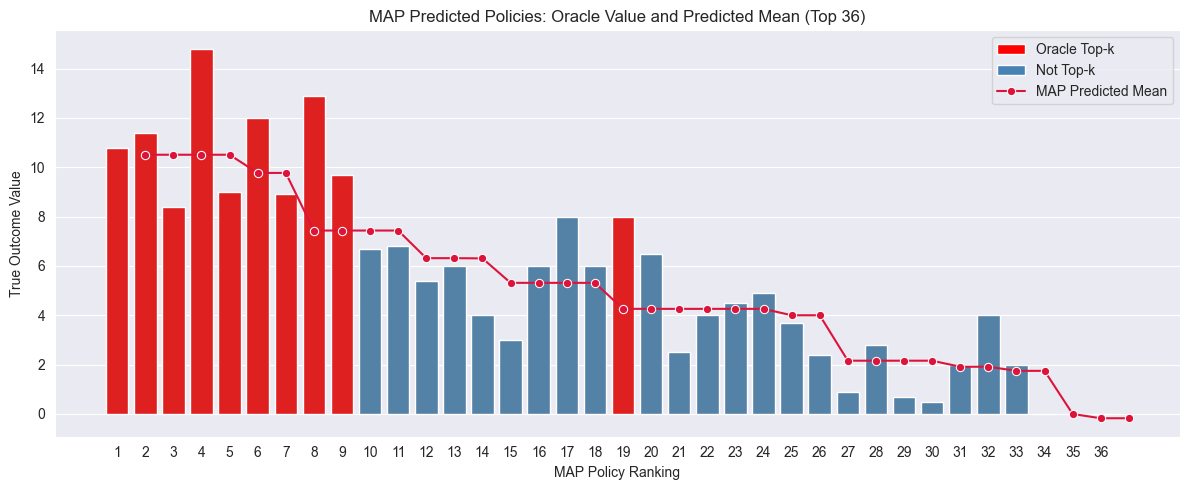

In [63]:
print("This plot shows the true (oracle) value for each of the top N MAP-predicted policies. ")
print("Red bars indicate the policy is in the oracle top-k. The red line is the MAP-predicted value for each ranked policy.")

import pandas as pd

df = pd.DataFrame({
    "MAP_Rank": np.arange(1, N+1),
    "Policy_Idx": sorted_idx[:N],
    "MAP_Pred": sorted_means[:N],
    "Oracle_Value": oracle_beta[sorted_idx[:N]],
    "Oracle_Rank": oracle_ranks[sorted_idx[:N]],
    "Is_TopK": [idx in top_k_indices for idx in sorted_idx[:N]]
})

plt.figure(figsize=(12,5))
sns.barplot(
    x="MAP_Rank", y="Oracle_Value", data=df,
    hue="Is_TopK", dodge=False,
    palette={True: "red", False: "steelblue"},
    alpha=1, edgecolor='white'
)
sns.lineplot(
    x="MAP_Rank", y="MAP_Pred", data=df,
    marker="o", color="crimson", label="MAP Predicted Mean"
)
plt.ylabel("True Outcome Value")
plt.xlabel("MAP Policy Ranking")
plt.title(f"MAP Predicted Policies: Oracle Value and Predicted Mean (Top {N})")
handles, labels = plt.gca().get_legend_handles_labels()
# Fix legend so that it clearly shows color mapping and the line
from matplotlib.patches import Patch
new_handles = [
    Patch(facecolor='red', edgecolor='white', label='Oracle Top-k'),
    Patch(facecolor='steelblue', edgecolor='white', label='Not Top-k'),
    handles[-1]  # The line for MAP Predicted Mean
]
plt.legend(handles=new_handles, title="")
plt.xticks(np.arange(-1, N, 1)+1)
plt.tight_layout()
plt.show()

This plot shows the regret (difference in true outcome vs. true best) for the policies that the MAP chose as its top N.
Lower is better; zero means the MAP-picked policy matches the true best.


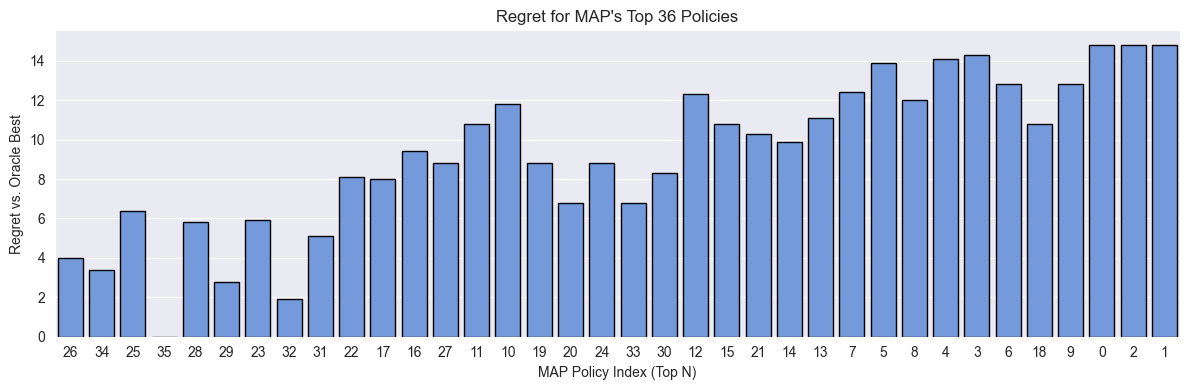

MAP top-36 min regret: 0.000  max regret: 14.800


In [68]:
# For each policy in MAP order, compute its regret vs. oracle-best
print("This plot shows the regret (difference in true outcome vs. true best) for the policies that the MAP chose as its top N.")
print("Lower is better; zero means the MAP-picked policy matches the true best.")

regrets_per_policy = oracle_beta[top_k_indices[0]] - oracle_beta[sorted_idx[:N]]

policy_labels = [str(idx) for idx in sorted_idx[:N]]
plt.figure(figsize=(12,4))
sns.barplot(x=policy_labels, y=regrets_per_policy, color="cornflowerblue", edgecolor="black")
plt.ylabel("Regret vs. Oracle Best")
plt.xlabel("MAP Policy Index (Top N)")
plt.title(f"Regret for MAP's Top {N} Policies")
plt.tight_layout()
plt.show()
# TODO careful with empty
print(f"MAP top-{N} min regret: {regrets_per_policy.min():.3f}  max regret: {regrets_per_policy.max():.3f}")

**Regression!**: for MAP predicted mean for a policy and the true mean

Regression results: R2 = 0.803, Slope = 0.72, Intercept = 1.02
This scatterplot shows, for the MAP's top N policies, the predicted mean (y-axis) vs. the true (oracle) value (x-axis).


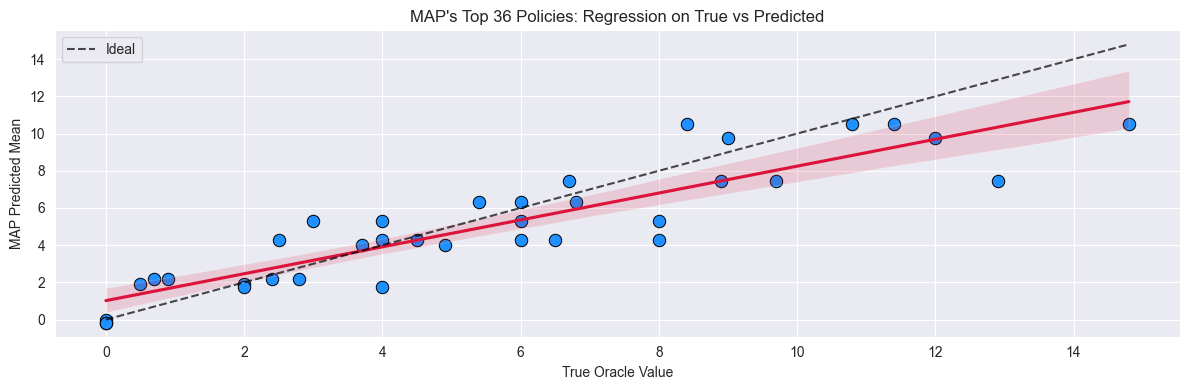

In [71]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Remove NaNs for regression
mask = ~np.isnan(df.MAP_Pred) & ~np.isnan(df.Oracle_Value)
X = df.Oracle_Value[mask].values.reshape(-1, 1)
y = df.MAP_Pred[mask].values
model = LinearRegression().fit(X, y)
y_pred = model.predict(X)
r2 = r2_score(y, y_pred)
slope = model.coef_[0]
intercept = model.intercept_
print(f"Regression results: R2 = {r2:.3f}, Slope = {slope:.2f}, Intercept = {intercept:.2f}")

print("This scatterplot shows, for the MAP's top N policies, the predicted mean (y-axis) vs. the true (oracle) value (x-axis).")
plt.figure(figsize=(12,4))
sns.scatterplot(x="Oracle_Value", y="MAP_Pred", data=df, color="dodgerblue", s=80, edgecolor="black")
sns.regplot(x="Oracle_Value", y="MAP_Pred", data=df, scatter=False, color="crimson", line_kws={'label':"Regression"})
plt.plot(
    [df.Oracle_Value.min(), df.Oracle_Value.max()],
    [df.Oracle_Value.min(), df.Oracle_Value.max()],
    'k--', alpha=0.7, label="Ideal"
)
plt.xlabel("True Oracle Value")
plt.ylabel("MAP Predicted Mean")
plt.title(f"MAP's Top {N} Policies: Regression on True vs Predicted")
plt.legend()
plt.tight_layout()
plt.show()

In [70]:
print("This plot shows the true value (orange bars) and MAP-predicted mean (red line) for the best policies, ranked by their actual best order.")
print("It helps diagnose whether MAP predictions are systematically biased for the actual best policies.")

plt.figure(figsize=(12,4))
sns.barplot(x="Oracle_Rank", y="Oracle_Value", data=df, color="orange", edgecolor="black", label="Oracle Value")
sns.lineplot(x="Oracle_Rank", y="MAP_Pred", data=df, marker="o", color="crimson", label="MAP Prediction")
plt.ylabel("Value")
plt.xlabel("Oracle Policy Rank")
plt.title(f"Oracle Top {N} Policies: True vs MAP Predicted Mean")
plt.legend()
plt.xticks(np.arange(-1, N, 1)+1)
plt.tight_layout()
plt.show()
print("Oracle top-N: Min/Max regret (MAP predicted minus true):",
      (df2.Oracle_Value - df2.MAP_Pred).min(), (df2.Oracle_Value - df2.MAP_Pred).max())

This plot shows the true value (orange bars) and MAP-predicted mean (red line) for the best policies, ranked by their actual best order.
It helps diagnose whether MAP predictions are systematically biased for the actual best policies.


NameError: name 'df2' is not defined

<Figure size 1200x400 with 0 Axes>

## across the RPS

How often are policies pooled together with the best arm?

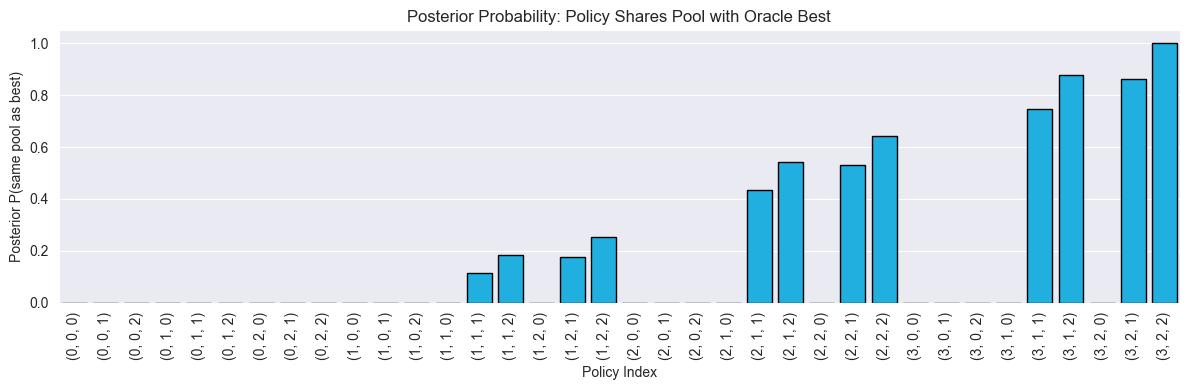

In [167]:
# for each partition in the RPS, for each policy, check if in the same pool as the oracle best arm
# posterior average - fro each policy, what fraction of posterior mass puts it in the same pool as the oracle best?
# For each partition, track which policies are in the same pool as the oracle best arm
best_arm_idx = top_k_indices[0]  # oracle best
in_same_pool_matrix = np.zeros((len(R_set_total), num_policies), dtype=float)

for j, r_set in enumerate(R_set_total):
    pi_policies_profiles_r = {}
    for k, profile in enumerate(profiles):
        if len(R_profiles_total[k]) == 0:
            continue
        sigma_k = R_profiles_total[k].sigma[r_set[k]]
        if sigma_k is None:
            n_policies_profile = len(policies_profiles_masked[k])
            pi_policies_r_k = {i: 0 for i in range(n_policies_profile)}
        else:
            _, pi_policies_r_k = extract_pools(policies_profiles_masked[k], sigma_k)
        pi_policies_profiles_r[k] = pi_policies_r_k
    pi_pools_r, pi_policies_r = aggregate_pools(pi_policies_profiles_r, policies_ids_profiles)
    # Find the pool id for best arm
    if best_arm_idx not in pi_policies_r:
        continue
    best_arm_pool = pi_policies_r[best_arm_idx]
    for idx in pi_policies_r:
        in_same_pool_matrix[j, idx] = (pi_policies_r[idx] == best_arm_pool)

# Posterior-weighted "same pool" probabilities for each policy
in_same_pool_prob = np.average(in_same_pool_matrix, axis=0, weights=weights)
plt.figure(figsize=(12,4))
sns.barplot(x=np.arange(num_policies), y=in_same_pool_prob, color="deepskyblue", edgecolor="black")
plt.xlabel("Policy Index")
plt.ylabel("Posterior P(same pool as best)")
plt.title("Posterior Probability: Policy Shares Pool with Oracle Best")
labels = [str(tuple(int(x) for x in p)) for p in all_policies]
plt.xticks(ticks=np.arange(num_policies), labels=labels, rotation=90)
plt.tight_layout()
plt.show()


Which policies are on the boundary most frequently?

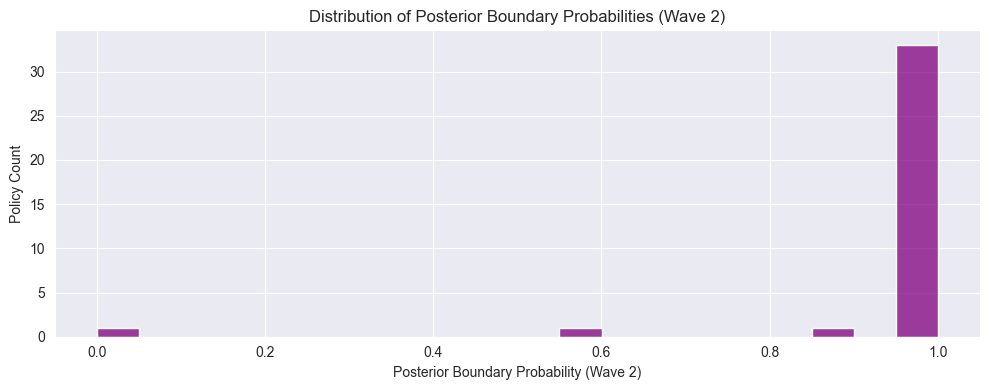

In [168]:
plt.figure(figsize=(10,4))
sns.histplot(posterior_boundary_probs_2, bins=20, color="purple", edgecolor="white")
plt.xlabel('Posterior Boundary Probability (Wave 2)')
plt.ylabel('Policy Count')
plt.title('Distribution of Posterior Boundary Probabilities (Wave 2)')
plt.tight_layout()
plt.show()

How robust is the identification of the best arm / pool across the RPS?

Policies identified as best in any partition (index, count):
Policy 13: 493 times
Policy 14: 420 times
Policy 16: 420 times
Policy 17: 74 times
Policy 19: 200 times
Policy 20: 73 times
Policy 22: 573 times
Policy 23: 74 times
Policy 25: 74 times
Policy 28: 616 times
Policy 29: 85 times
Policy 31: 833 times
Policy 32: 75 times
Policy 34: 75 times


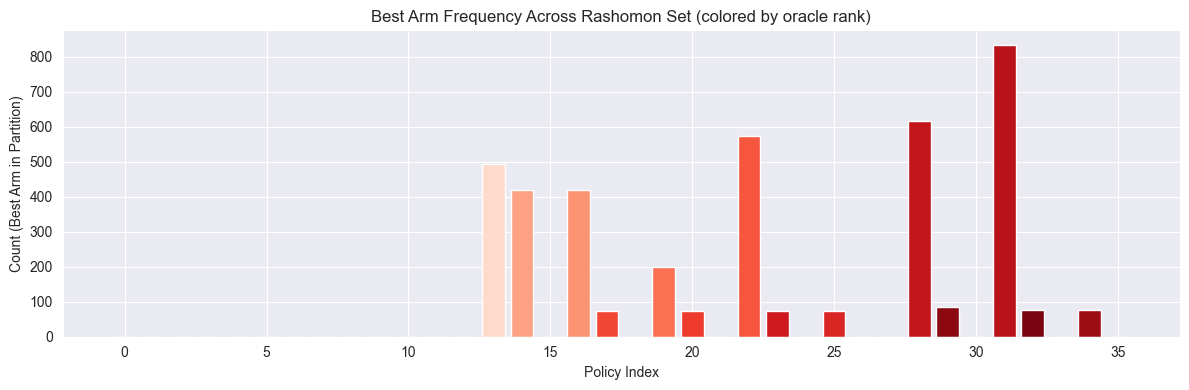

In [169]:
# Track which arm is best in each partition
best_arm_counts = np.zeros(num_policies, dtype=int)
for i in range(len(R_set_total)):
    idx = policy_indices_all[i][np.argmax(policy_means_all[i])]
    best_arm_counts[idx] += 1
print("Policies identified as best in any partition (index, count):")
for idx, count in enumerate(best_arm_counts):
    if count > 0:
        print(f"Policy {idx}: {count} times")
# TODO says no cm.get_cmap...
from matplotlib import colormaps
# Normalize color by rank (lower is better)
oracle_rank_for_plot = np.array([oracle_ranks[i] for i in range(num_policies)])
norm = plt.Normalize(oracle_rank_for_plot.min(), oracle_rank_for_plot.max())
colors = colormaps["Reds"](1 - 1.3*norm(oracle_rank_for_plot))  # "Best" = brightest

plt.figure(figsize=(12,4))
bars = plt.bar(np.arange(num_policies), best_arm_counts, color=colors)
plt.xlabel("Policy Index")
plt.ylabel("Count (Best Arm in Partition)")
plt.title("Best Arm Frequency Across Rashomon Set (colored by oracle rank)")
plt.tight_layout()
plt.show()
# also remove the pasted list it looks bad

#### What is the average pool size for each policy in the posterior?

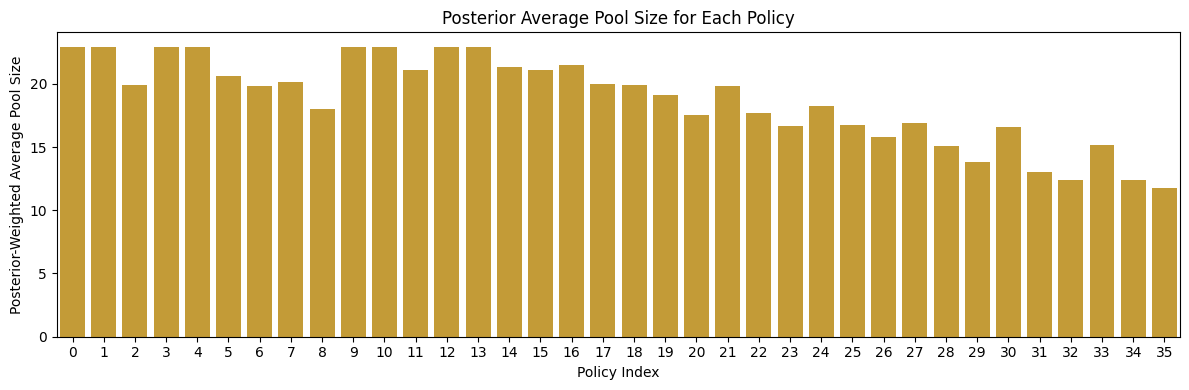

In [174]:
avg_pool_size = np.zeros(num_policies)
for i in range(len(R_set_total)):
    pi_policies_r = {}
    for k, profile in enumerate(profiles):
        if len(R_profiles_total[k]) == 0:
            continue
        sigma_k = R_profiles_total[k].sigma[R_set_total[i][k]]
        if sigma_k is None:
            n_policies_profile = len(policies_profiles_masked[k])
            pi_policies_r_k = {i: 0 for i in range(n_policies_profile)}
        else:
            _, pi_policies_r_k = extract_pools(policies_profiles_masked[k], sigma_k)
        pi_policies_r.update({policies_ids_profiles[k][j]: pool for j, pool in pi_policies_r_k.items()})
    pool_counts = {}
    for pool_id in set(pi_policies_r.values()):
        count = sum(1 for v in pi_policies_r.values() if v == pool_id)
        for idx in [k for k,v in pi_policies_r.items() if v==pool_id]:
            pool_counts[idx] = count
    for idx in pool_counts:
        avg_pool_size[idx] += pool_counts[idx] * weights[i]
avg_pool_size /= weights.sum()
plt.figure(figsize=(12,4))
sns.barplot(x=np.arange(num_policies), y=avg_pool_size, color="goldenrod")
plt.xlabel("Policy Index")
plt.ylabel("Posterior-Weighted Average Pool Size")
plt.title("Posterior Average Pool Size for Each Policy")
plt.tight_layout()
plt.show()